In [44]:

# coding: utf-8

# In[1]:

#trying to rewrite so faster using numpy historgram
#plotting and data analysis for global cold wakes
#from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import os
import time
import datetime as dt
import xarray as xr
from datetime import datetime
import pandas
import matplotlib.pyplot as plt
import numpy as np
import math
import geopy.distance
from math import sin, pi
from scipy import interpolate
from scipy import stats

#functions for running storm data
import sys

####################you will need to change some paths here!#####################
#list of input directories
dir_storm_info='f:/data/tc_wakes/database/info/'
dir_out='f:/data/tc_wakes/database/sst/'
#################################################################################

#start to look at data and make some pdfs

date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958

map_lats=np.arange(-90,90,.25)
map_lons=np.arange(-180,180,.25)
imap_lats = map_lats.size
imap_lons = map_lons.size
  
#for iyr_storm in range(2002,2017):
for iyr_storm in range(2002,2018):
    #init arrays
    init_data=0
    map_sum,map_cnt,map_max = np.zeros([imap_lats,imap_lons]),np.zeros([imap_lats,imap_lons]),np.zeros([imap_lats,imap_lons])
    map_sum_recov,map_cnt_recov = np.zeros([imap_lats,imap_lons]),np.zeros([imap_lats,imap_lons])
#    for inum_storm in range(0,100): 
    for inum_storm in range(16,17): 
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track.nc'
        exists = os.path.isfile(filename)
        if not exists:
            continue
        print(filename)
        ds_storm_info=xr.open_dataset(filename)
        ds_storm_info = ds_storm_info.sel(j2=0)
        ds_storm_info.close()
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined_data.nc'
        ds_all = xr.open_dataset(filename)
        ds_all['spd']=np.sqrt(ds_all.uwnd**2+ds_all.vwnd**2)
        ds_all.close()
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_MLD_data_v2.nc'
        ds_all2 = xr.open_dataset(filename)
        ds_all2.close()
        if abs(ds_all.lon[-1]-ds_all.lon[0])>180:
            ds_all.coords['lon'] = np.mod(ds_all['lon'], 360)
            ds_storm_info['lon'] = np.mod(ds_storm_info['lon'], 360)
        max_lat = ds_storm_info.lat.max()
        #remove all data outsice 100km/800km or cold wake >0 or <-10
        if max_lat<0:
            cond = ((((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm<=0)) | 
            ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm>0))) 
            & (ds_all.coldwake_max<=-.1) & (ds_all.coldwake_max>=-10))
        else:
            cond = ((((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm<0)) | 
            ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm>=0))) 
            & (ds_all.coldwake_max<=-.1) & (ds_all.coldwake_max>=-10))
        subset = ds_all.where(cond)
        subset2 = ds_all2.where(cond)

        #create coldwake anomaly with nan for all values before wmo storm time
        subset['sst_anomaly']=subset.analysed_sst-subset.sst_prestorm
    #    for i in range(0,xdim):
    #        for j in range (0,ydim):
    #            if np.isnan(subset.closest_storm_index[j,i]):
    #                continue
    #            iend = subset.closest_storm_index[j,i].data.astype(int)
    #            subset.sst_anomaly[:iend,j,i]=np.nan

        #create array with day.frac since closest storm passage
        tdif_dy = (subset.time-subset.closest_storm_time_np64)/np.timedelta64(1, 'D')
    #    tdif_dy = tdif_dy.where(tdif_dy>=0,np.nan)
        subset['tdif_dy']=tdif_dy

        xdim,ydim,tdim = ds_all.lon.shape[0],ds_all.lat.shape[0],ds_all.time.shape[0]

        pdim=xdim*ydim
        pdim3=tdim*xdim*ydim
        print(xdim*ydim)
#        data = subset.coldwake_max
#        cbin1 = np.arange(-10, 0, 0.1)  #cold wake bins
#        bins=cbin1
#        hist1,mids = np.histogram(data,bins)[0],0.5*(bins[1:]+bins[:-1])
#        sum1 = np.cumsum(mids*hist1) 

        cbin1 = np.arange(-10, 0, 0.1)  #cold wake bins
        bins=cbin1
        x= np.reshape(subset.coldwake_max.data,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist1,mids1=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum1=stats.binned_statistic(x,v, 'sum', bins)[0]

        cbin2 = np.arange(0,8)  #day to max, plot histogram of when cold wake max happens
        bins=cbin2
        x= np.reshape(subset.coldwake_hrtomaxcold.data/24,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist2,mids2=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum2=stats.binned_statistic(x,v, 'sum', bins)[0]

        cbin3 = np.arange(0,50)  #dy to recovery
        bins=cbin3
        x= np.reshape(subset.coldwake_dytorecovery.data,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist3,mids3=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum3=stats.binned_statistic(x,v, 'sum', bins)[0]

        cbin4 = np.arange(0,400,10)  #max cold wake as function of MLD at start of storm
        bins=cbin4
        x= np.reshape(subset.dbss_obml[0,:,:].data,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist4,mids4=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum4=stats.binned_statistic(x,v, 'sum', bins)[0]

        cbin4a = np.arange(0,400,10)  #max cold wake as function of MLD at start of storm
        bins=cbin4a
        x= np.reshape(subset2.mxldepth[1,:,:].data,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist4a,mids4a=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum4a=stats.binned_statistic(x,v, 'sum', bins)[0]
        
        
        cbin5 = np.arange(0,200,5)  #max cold wake as function of wmo max storm wind speed
        bins=cbin5
        x= np.reshape(subset.wmo_storm_wind.data,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist5,mids5=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum5=stats.binned_statistic(x,v, 'sum', bins)[0]

        cbin6 = np.arange(0,200,5)  #max cold wake as function of wmo max storm translation speed
        bins=cbin6
        x= np.reshape(subset.wmo_storm_speed_kmhr.data,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist6,mids6=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum6=stats.binned_statistic(x,v, 'sum', bins)[0]

        cbin7 = np.arange(-10,50,1)  #cold wake recovery as function of time
        bins = cbin7
        x= np.reshape(subset.tdif_dy.data,(pdim3))
        v = np.reshape(subset.sst_anomaly.data,(pdim3))
        hist7,mids7=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum7=stats.binned_statistic(x,v, 'sum', bins)[0]

        x1= np.reshape(subset.wmo_storm_speed_kmhr.data,(pdim))
        x3= np.reshape(subset.wmo_storm_wind.data,(pdim))
        b1= cbin6 #np.arange(0,200,1)
        b3= cbin5 #np.arange(0,200,1)
        dbins=np.vstack((b1,b3)).T
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist8=stats.binned_statistic_2d(x1,x3,v,'count', bins=dbins.T)[0]
        sum8=stats.binned_statistic_2d(x1,x3,v, 'sum', bins=dbins.T)[0]

        x1= np.reshape(subset.wmo_storm_speed_kmhr.data,(pdim))
        x2= np.reshape(subset.dbss_obml[0,:,:].data,(pdim))
        x3= np.reshape(subset.wmo_storm_wind.data,(pdim))
        x=np.vstack((x1,x2,x3))
        b1= cbin6 #np.arange(0,200,1)
        b2= cbin4 #np.arange(0,600,3)
        b3= cbin5 #np.arange(0,200,1)
        dbins=np.vstack((b1,b2,b3)).T
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist9=stats.binned_statistic_dd(x.T,v,'count', bins=dbins.T)[0]
        sum9=stats.binned_statistic_dd(x.T,v, 'sum', bins=dbins.T)[0]    

        if init_data == 0:
            sv_sum1,sv_cnt1,sv_bin1 = sum1,hist1,cbin1
            sv_sum2,sv_cnt2,sv_bin2 = sum2,hist2,cbin2
            sv_sum3,sv_cnt3,sv_bin3 = sum3,hist3,cbin3
            sv_sum4,sv_cnt4,sv_bin4 = sum4,hist4,cbin4
            sv_sum4a,sv_cnt4a,sv_bin4a = sum4a,hist4a,cbin4a
            sv_sum5,sv_cnt5,sv_bin5 = sum5,hist5,cbin5
            sv_sum6,sv_cnt6,sv_bin6 = sum6,hist6,cbin6
            sv_sum7,sv_cnt7,sv_bin7 = sum7,hist7,cbin7
            sv_sum8,sv_cnt8 = sum8,hist8
            sv_sum9,sv_cnt9 = sum9,hist9
            init_data=1
        else:
            sv_sum1+= sum1
            sv_cnt1+= hist1
            sv_sum2+= sum2
            sv_cnt2+= hist2
            sv_sum3+= sum3
            sv_cnt3+= hist3
            sv_sum4+= sum4
            sv_cnt4+= hist4
            sv_sum4a+= sum4a
            sv_cnt4a+= hist4a
            sv_sum5+= sum5
            sv_cnt5+= hist5      
            sv_sum6+= sum6
            sv_cnt6+= hist6           
            sv_sum7+= sum7
            sv_cnt7+= hist7           
            sv_sum8+= sum8
            sv_cnt8+= hist8           
            sv_sum9+= sum9
            sv_cnt9+= hist9           

        #put on global map
        tem = subset.coldwake_max.interp(lat=map_lats,lon=map_lons)
        tem=tem.fillna(0)
        temc=(tem/tem).fillna(0)
        map_sum+=tem
        map_cnt+=temc
        map_max=np.where(tem.data < map_max, tem,map_max)  #where tem<max put tem value in otherwise leave max
        tem = subset.coldwake_dytorecovery.interp(lat=map_lats,lon=map_lons)
        tem=tem.fillna(0)
        temc=(tem/tem).fillna(0)
        map_sum_recov+=tem
        map_cnt_recov+=temc

    m1=xr.DataArray(map_sum, coords={'lat': map_lats, 'lon':map_lons}, dims=('lat', 'lon'))        
    m2=xr.DataArray(map_cnt, coords={'lat': map_lats, 'lon':map_lons}, dims=('lat', 'lon'))        
    m3=xr.DataArray(map_max, coords={'lat': map_lats, 'lon':map_lons}, dims=('lat', 'lon'))        
    m4=xr.DataArray(map_sum_recov, coords={'lat': map_lats, 'lon':map_lons}, dims=('lat', 'lon'))        
    m5=xr.DataArray(map_cnt_recov, coords={'lat': map_lats, 'lon':map_lons}, dims=('lat', 'lon'))        
    ds=xr.Dataset(data_vars={'sum1': (('coldw'),sv_sum1),
                             'cnt1': (('coldw'),sv_cnt1),
                             'sum2': (('dymax'),sv_sum2),
                             'cnt2': (('dymax'),sv_cnt2),
                             'sum3': (('dyrec'),sv_sum3),
                             'cnt3': (('dyrec'),sv_cnt3),
                             'sum4': (('mld'),sv_sum4),
                             'cnt4': (('mld'),sv_cnt4),
                             'sum4a': (('mld2'),sv_sum4a),
                             'cnt4a': (('mld2'),sv_cnt4a),
                             'sum5': (('wnd'),sv_sum5),
                             'cnt5': (('wnd'),sv_cnt5),
                             'sum6': (('tspd'),sv_sum6),
                             'cnt6': (('tspd'),sv_cnt6),
                             'sum7': (('dtime'),sv_sum7),
                             'cnt7': (('dtime'),sv_cnt7),
                             'sum8': (('tspd','wnd'),sv_sum8),
                             'cnt8': (('tspd','wnd'),sv_cnt8),
                             'sum9': (('tspd','mld','wnd'),sv_sum9),
                             'cnt9': (('tspd','mld','wnd'),sv_cnt9),
                                 'map_sum': (('lat','lon'),m1),
                                'map_cnt': (('lat','lon'),m2),
                                'map_max': (('lat','lon'),m3),
                                 'map_sum_recov': (('lat','lon'),m4),
                                'map_cnt_recov': (('lat','lon'),m5)
                               },
                                 coords={'coldw':cbin1[0:-1],
                                         'dymax':cbin2[0:-1],
                                         'dyrec':cbin3[0:-1],
                                         'mld':cbin4[0:-1],
                                         'wnd':cbin5[0:-1],
                                         'tspd':cbin6[0:-1],
                                         'dtime':cbin7[0:-1],
                                         'lat':map_lats,'lon':map_lons})

   # filename='f:/data/tc_wakes/database/results/hist_sum_'+str(iyr_storm)+'.nc'
   # ds.to_netcdf(filename)


f:/data/tc_wakes/database/sst/2015/016_interpolated_track.nc
19454


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


In [ ]:
ds.map_sum.plot()

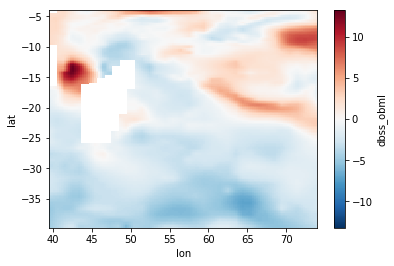

In [42]:
(ds_all2.dbss_obml[4,:,:]-ds_all2.dbss_obml[10,:,:]).plot()

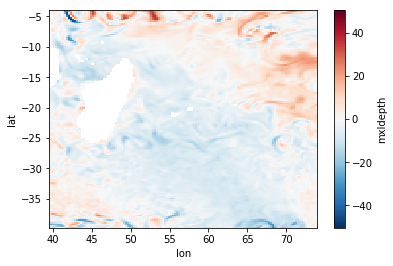

In [43]:
(ds_all2.mxldepth[4,:,:]-ds_all2.mxldepth[10,:,:]).plot()

In [125]:

# coding: utf-8

# In[1]:

#trying to rewrite so faster using numpy historgram
#plotting and data analysis for global cold wakes
#from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import os
import time
import datetime as dt
import xarray as xr
from datetime import datetime
import pandas
import matplotlib.pyplot as plt
import numpy as np
import math
import geopy.distance
from math import sin, pi
from scipy import interpolate
from scipy import stats

#functions for running storm data
import sys

####################you will need to change some paths here!#####################
#list of input directories
dir_storm_info='f:/data/tc_wakes/database/info/'
dir_out='f:/data/tc_wakes/database/sst/'
#################################################################################

#start to look at data and make some pdfs

date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958

map_lats=np.arange(-90,90,.25)
map_lons=np.arange(-180,180,.25)
imap_lats = map_lats.size
imap_lons = map_lons.size
  
#for iyr_storm in range(2002,2017):
for iyr_storm in range(2002,2003): #2002,2018):
    #init arrays
    init_data=0
    map_sum,map_cnt,map_max = np.zeros([imap_lats,imap_lons]),np.zeros([imap_lats,imap_lons]),np.zeros([imap_lats,imap_lons])
    map_sum_recov,map_cnt_recov = np.zeros([imap_lats,imap_lons]),np.zeros([imap_lats,imap_lons])
#    for inum_storm in range(0,100): 
    for inum_storm in range(16,20): 
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track.nc'
        exists = os.path.isfile(filename)
        if not exists:
            continue
        print(filename)
        ds_storm_info=xr.open_dataset(filename)
        ds_storm_info = ds_storm_info.sel(j2=0)
        ds_storm_info.close()
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined_data.nc'
        ds_all = xr.open_dataset(filename)
        ds_all['spd']=np.sqrt(ds_all.uwnd**2+ds_all.vwnd**2)
        ds_all.close()
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_MLD_data_v2.nc'
        ds_all2 = xr.open_dataset(filename)
        ds_all2.close()
        if abs(ds_all.lon[-1]-ds_all.lon[0])>180:
            ds_all.coords['lon'] = np.mod(ds_all['lon'], 360)
            ds_storm_info['lon'] = np.mod(ds_storm_info['lon'], 360)
        max_lat = ds_storm_info.lat.max()
        #remove all data outsice 100km/800km or cold wake >0 or <-10
        if max_lat<0:
            cond = ((((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm<=0)) | 
            ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm>0))) 
            & (ds_all.coldwake_max<=-.1) & (ds_all.coldwake_max>=-10))
        else:
            cond = ((((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm<0)) | 
            ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm>=0))) 
            & (ds_all.coldwake_max<=-.1) & (ds_all.coldwake_max>=-10))
        subset = ds_all.where(cond)
        subset2 = ds_all2.where(cond)

        #create coldwake anomaly with nan for all values before wmo storm time
        subset['sst_anomaly']=subset.analysed_sst-subset.sst_prestorm
    #    for i in range(0,xdim):
    #        for j in range (0,ydim):
    #            if np.isnan(subset.closest_storm_index[j,i]):
    #                continue
    #            iend = subset.closest_storm_index[j,i].data.astype(int)
    #            subset.sst_anomaly[:iend,j,i]=np.nan

        #create array with day.frac since closest storm passage
        tdif_dy = (subset.time-subset.closest_storm_time_np64)/np.timedelta64(1, 'D')
    #    tdif_dy = tdif_dy.where(tdif_dy>=0,np.nan)
        subset['tdif_dy']=tdif_dy

        xdim,ydim,tdim = ds_all.lon.shape[0],ds_all.lat.shape[0],ds_all.time.shape[0]


#only keep sst_anomaly from 5 days before storm to cold wake recovery
        ds_all['sst_anomaly']=ds_all.analysed_sst-ds_all.analysed_sst_clim-ds_all.sst_prestorm_clim
        for i in range(ydim):
            for j in range(xdim):
                if np.isnan(ds_all.coldwake_max[i,j]):
                    continue
                istart = int(ds_all.closest_storm_index[i,j].data-5)
                if istart<0:
                    istart=0
                iend = int(ds_all.closest_storm_index[i,j].data+ds_all.coldwake_dytorecovery[i,j].data)
                if iend>tdim:
                    iend=tdim
                ds_all.sst_anomaly[:istart,i,j]=np.nan
                ds_all.sst_anomaly[iend:,i,j]=np.nan
        cond = ((((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm<0)) | 
        ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm>=0))) 
        & (ds_all.coldwake_max<=-.1) & (ds_all.coldwake_max>=-10))
        subset_cold = ds_all.where(cond)       
#end only keep sst_anomaly code
        
        
        pdim=xdim*ydim
        pdim3=tdim*xdim*ydim
        print(xdim*ydim)
#        data = subset.coldwake_max
#        cbin1 = np.arange(-10, 0, 0.1)  #cold wake bins
#        bins=cbin1
#        hist1,mids = np.histogram(data,bins)[0],0.5*(bins[1:]+bins[:-1])
#        sum1 = np.cumsum(mids*hist1) 

        cbin1 = np.arange(-10, 0, 0.1)  #cold wake bins
        bins=cbin1
        x= np.reshape(subset.coldwake_max.data,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist1,mids1=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum1=stats.binned_statistic(x,v, 'sum', bins)[0]

        cbin2 = np.arange(0,8)  #day to max, plot histogram of when cold wake max happens
        bins=cbin2
        x= np.reshape(subset.coldwake_hrtomaxcold.data/24,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist2,mids2=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum2=stats.binned_statistic(x,v, 'sum', bins)[0]

        cbin3 = np.arange(0,50)  #dy to recovery
        bins=cbin3
        x= np.reshape(subset.coldwake_dytorecovery.data,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist3,mids3=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum3=stats.binned_statistic(x,v, 'sum', bins)[0]

        cbin4 = np.arange(0,400,10)  #max cold wake as function of MLD at start of storm
        bins=cbin4
        x= np.reshape(subset.dbss_obml[0,:,:].data,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist4,mids4=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum4=stats.binned_statistic(x,v, 'sum', bins)[0]

        cbin4a = np.arange(0,400,10)  #max cold wake as function of MLD at start of storm
        bins=cbin4a
        x= np.reshape(subset2.mxldepth[1,:,:].data,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist4a,mids4a=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum4a=stats.binned_statistic(x,v, 'sum', bins)[0]
        
        
        cbin5 = np.arange(0,200,5)  #max cold wake as function of wmo max storm wind speed
        bins=cbin5
        x= np.reshape(subset.wmo_storm_wind.data,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist5,mids5=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum5=stats.binned_statistic(x,v, 'sum', bins)[0]

        cbin6 = np.arange(0,200,5)  #max cold wake as function of wmo max storm translation speed
        bins=cbin6
        x= np.reshape(subset.wmo_storm_speed_kmhr.data,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist6,mids6=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum6=stats.binned_statistic(x,v, 'sum', bins)[0]

        cbin7 = np.arange(-10,50,1)  #cold wake recovery as function of time
        bins = cbin7
        x= np.reshape(tdif_dy.data,(pdim3))
        v = np.reshape(subset_cold.sst_anomaly.data,(pdim3))
        x = x[~np.isnan(v)]
        v = v[~np.isnan(v)]
        hist7,mids7=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum7=stats.binned_statistic(x,v, 'sum', bins)[0]

 

f:/data/tc_wakes/database/sst/2002/017_interpolated_track.nc
36815
f:/data/tc_wakes/database/sst/2002/018_interpolated_track.nc
29896
f:/data/tc_wakes/database/sst/2002/019_interpolated_track.nc
17822


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


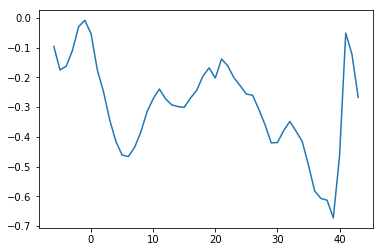

In [127]:
plt.plot(bins[0:-1],sum7/hist7)

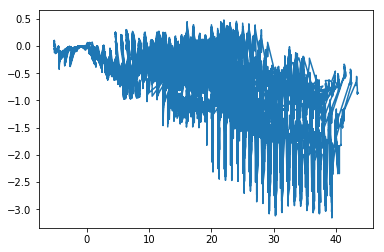

In [97]:
plt.plot(x,v)

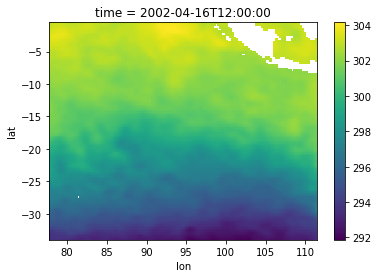

In [122]:
#ds_all.sst_prestorm_clim.plot()
#((ds_all.analysed_sst[15,:,:]-ds_all.analysed_sst_clim[15,:,:])-ds_all.sst_prestorm_clim ).plot()
#((ds_all.analysed_sst[15,:,:]-ds_all.sst_prestorm_clim) ).plot()
#((ds_all.analysed_sst[30,:,:]-ds_all.analysed_sst_clim[30,:,:])).plot()
#plt.plot(ds_all.analysed_sst[40,40,50]-ds_all.analysed_sst_clim[40,40,50])-ds_all.sst_prestorm_clim[40,50])
#ds_all.sst_anomaly[15,:,:].plot()

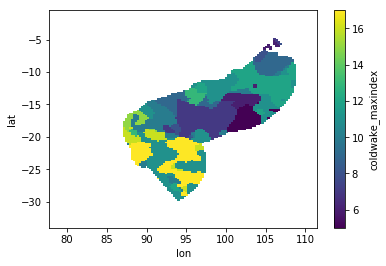

In [8]:
ds_all.coldwake_maxindex.plot()

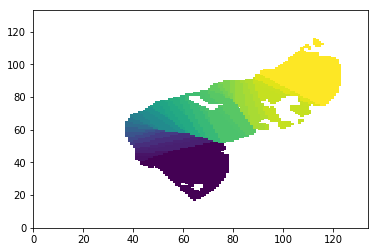

In [14]:
plt.pcolormesh(tdif_dy[20,:,:])

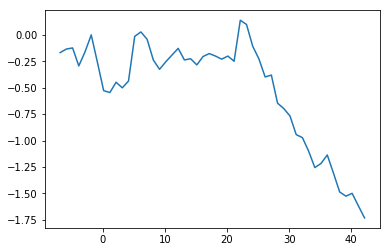

In [20]:
plt.plot(tdif_dy[:,60,60],subset.sst_anomaly[:,60,60])

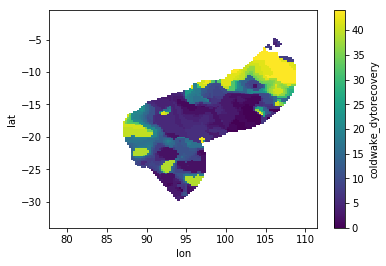

In [23]:
ds_all.coldwake_dytorecovery.plot()

In [25]:
cond = ((((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm<0)) | 
((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm>=0))) 
& (ds_all.coldwake_max<=-.1) & (ds_all.coldwake_max>=-10))
subset_cold = ds_all.where(cond)



In [56]:
#        tdif_dy = (subset.time-subset.closest_storm_time_np64)/np.timedelta64(1, 'D')
        

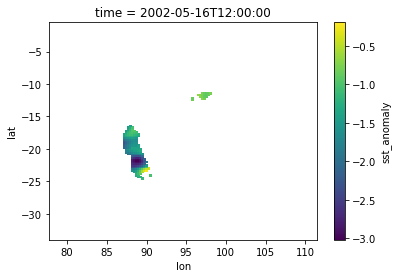

In [71]:
subset_cold.sst_anomaly[45,:,:].plot()

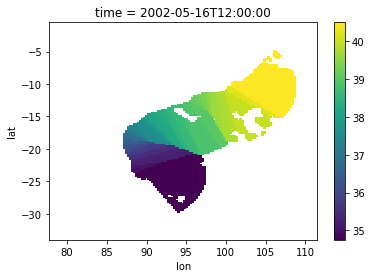

In [72]:
tdif_dy[45,:,:].plot()


In [46]:
j

46

In [ ]:
subset_cold